Simulation as demonstration of the work,

```
Tuckerman, M. E., C. J. Mundy, and G. J. Martyna. "On the 
classical statistical mechanics of non-Hamiltonian systems." 
EPL (Europhysics Letters) 45.2 (1999): 149.
```

The paper describes simulating systems like,
\begin{align}
\dot{x} &= \xi(x)
\end{align}

The paper describes computing the Jacobian and Riemannian metric,
\begin{align}
\kappa(x) &= \sum_i \frac{\partial \dot{x}_i}{\partial x} \\
\dot{J}(x_t; x_0) &= \kappa(x_t) J \\
\sqrt{g_t} &= \sqrt{g_0} J^{-1}
\end{align}

Then the invariant entropy is,
\begin{align}
S(t) &= - \int dx \sqrt{g_t} f(x_t) \log f(x_t)
\end{align}

As an example, we will be integrating the decaying harmonic oscillator,
\begin{align}
\dot{q} &= p - \alpha q\\
\dot{p} &= -q
\end{align}

In this case, $ \kappa(x) = \frac{\partial \dot{q}}{q} = -\alpha $, so our Jacobian is simply,
\begin{align}
J(x_t; x_0) = e^{-\alpha t}
\end{align}

which we would naturally expect from a shrinking phase space. The path of the particle can be solved analytically,
\begin{align}
\left( \begin{matrix}
\dot{q}(t) \\
\dot{p}(t)
\end{matrix} \right) = 
\left( \begin{matrix}
-\alpha & 1 \\
-1      & 0
\end{matrix} \right)
\left( \begin{matrix}
q(t) \\
p(t)
\end{matrix} \right)
\end{align}

This gives,
\begin{align}
\left( \begin{matrix}
q(t) \\
p(t)
\end{matrix} \right) = 
\left( \begin{matrix}
q(0) \\
p(0)
\end{matrix} \right)
e^{\left( \begin{matrix}
-\alpha & 1 \\
-1      & 0
\end{matrix} \right) t}
\end{align}

Matrix([[alpha/2 + sqrt(alpha**2 - 4)/2, alpha/2 - sqrt(alpha**2 - 4)/2], [1, 1]]) Matrix([[-alpha/2 - sqrt((alpha - 2)*(alpha + 2))/2, 0], [0, -alpha/2 + sqrt((alpha - 2)*(alpha + 2))/2]])


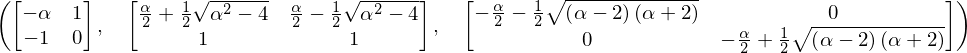

In [1]:
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex=True)

alpha = sympy.symbols('alpha')
U, D = sympy.Matrix([[-alpha, 1], [-1, 0]]).diagonalize()
print(U, D)
sympy.simplify(U * D * U**-1), U, D, 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def plogp(pk):
    rk = np.zeros(pk.shape)
    inds = pk > 0
    rk[inds] = pk[inds] * np.log(pk[inds])
    return rk

def evolve(z0, t, alpha=1e-1):
    alpha += 0j
    U, D = (np.array([[alpha/2 + np.sqrt(alpha**2 - 4)/2,
                       alpha/2 - np.sqrt(alpha**2 - 4)/2], [1, 1]]),
            np.array([[-alpha/2 - np.sqrt((alpha - 2)*(alpha + 2))/2, 0], 
                      [0, -alpha/2 + np.sqrt((alpha - 2)*(alpha + 2))/2]]))
    T = U.dot(np.diag(np.exp(np.diag(D) * t))).dot(np.linalg.inv(U))
    assert np.isclose(0.0, np.linalg.norm(np.imag(T)))
    return np.real(z0.dot(T))

T = np.arange(0, 100, 1e-1)
z0 = np.random.randn(int(1e4), 2)
alpha = 1.0

Here I produce 4 plots: Unscaled Phase space, Scaled Phase space, Unscaled Entropy, and Scaled Entropy. Note that in computing the scaled entropy, I simply compute entropy on the scaled phase space rather than including the Jacobian in the entropy integral. This is equivalent by a change in coordinates, but you might need to be careful with the coordinate transform if the Jacobian is coordinate dependent.

In [34]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

phase_bounds = [-5, 5]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.set_title('Unscaled Phase space')
ax1.set_xlim(phase_bounds)
ax1.set_ylim(phase_bounds)

ax2.set_title('Unscaled Entropy')
ax2.set_xlim([0, T[-1]])
ax2.set_ylim([0, 3])

ax3.set_title('Scaled Phase Space')
ax3.set_xlim(phase_bounds)
ax3.set_ylim(phase_bounds)

ax4.set_title('Scaled Entropy')
ax4.set_xlim([0, T[-1]])
ax4.set_ylim([0, 3])

scat_n = ax1.scatter(z0[0, :], z0[1, :])
entr_n, = ax2.plot([], [])
scat_s = ax3.scatter(z0[0, :], z0[1, :])
entr_s, = ax4.plot([], [])

S_n, S_s, dq, dp = [], [], 0.1, 0.1
def update(i):
    z = evolve(z0, T[i], alpha)
    scale = np.exp(alpha * T[i]/2)
    
    # Compute both unscaled and scaled entropy
    pk = np.histogram2d(z[:, 0], z[:, 1],
                        bins=(np.arange(phase_bounds[0], phase_bounds[1], dq),
                              np.arange(phase_bounds[0], phase_bounds[1], dp)),
                        normed=True)[0]
    S_n.append(-np.sum(dq*dp * plogp(pk.flatten())))
    pk = np.histogram2d(scale*z[:, 0], scale*z[:, 1],
                        bins=(np.arange(phase_bounds[0], phase_bounds[1], dq),
                              np.arange(phase_bounds[0], phase_bounds[1], dp)),
                        normed=True)[0]
    S_s.append(-np.sum(dq*dp * plogp(pk.flatten())))
    
    scat_n.set_offsets(z)
    entr_n.set_data(T[:i+1], np.array(S_n[:i+1])/S_n[0])
    
    scat_s.set_offsets(scale * z)
    entr_s.set_data(T[:i+1], np.array(S_s[:i+1])/S_s[0])
    
    return (scat_n,entr_n,scat_s,entr_s)
    
FuncAnimation(fig, update, interval=100, frames=T.size)